In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torch as torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [18]:
def combine_folders(source_folders, destination_folder):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    for source_folder in source_folders:
        for subfolder in ['NORMAL', 'PNEUMONIA']:
            source_path = os.path.join(source_folder, subfolder)
            dest_path = os.path.join(destination_folder, subfolder)
            
            # Create the subfolder in the destination if it doesn't exist
            os.makedirs(dest_path, exist_ok=True)
            
            # Copy all files from source to destination
            for item in os.listdir(source_path):
                s = os.path.join(source_path, item)
                d = os.path.join(dest_path, item)
                if os.path.isfile(s):
                    shutil.copy2(s, d)

# Set up the source and destination folders
source_folders = ['dataset_gan', 'dataset']
destination_folder = 'combined_data'

# Run the function to combine folders
combine_folders(source_folders, destination_folder)

print("Folders combined successfully!")

Folders combined successfully!


In [21]:
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert images to grayscale if not already
    transforms.RandomResizedCrop(size =256, scale= (0.8, 1.0) ),
    #transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size =224),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
])

# Load the combined dataset
combined_dataset = datasets.ImageFolder(destination_folder, transform=transform)

# Calculate split sizes
total_size = len(combined_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

# Split the combined dataset
indices = list(range(total_size))
np.random.seed(25)  # Ensure reproducibility
np.random.shuffle(indices)

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]

# Create subset datasets
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, valid_indices)
test_dataset = Subset(combined_dataset, test_indices)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print dataset sizes
print(f'Total samples: {total_size}')
print(f'Train samples: {train_size}')
print(f'Validation samples: {valid_size}')
print(f'Test samples: {test_size}')

Total samples: 8416
Train samples: 5891
Validation samples: 1262
Test samples: 1263


In [22]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Downsampling layer if there's a need to adjust dimensions
        self.downsample = downsample

    def forward(self, x):
        residual = x
        # Apply downsampling if defined
        if self.downsample is not None:
            residual = self.downsample(x)

        # First convolutional operation
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Second convolutional operation
        out = self.conv2(out)
        out = self.bn2(out)

        # Adding back the residual
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=36):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Stack of residual blocks forming the four layers of the ResNet
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        # Handle downsampling at the first block of the layer if needed
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
        # Create the layer by stacking residual blocks
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))  # No stride change, no downsampling

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Apply all four layers in sequence
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Pooling and classification
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def resnet34(num_classes=36):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)

In [23]:
# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on: {device}')

model = resnet34().to(device)
print(model)

Training on: cuda:0
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_val_model(model, train_loader, validation_loader, criterion, optimizer, epochs):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0.0
        total_train = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            targets = targets.squeeze().long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
                targets = targets.squeeze().long()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        avg_val_loss = val_loss / len(validation_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(validation_accuracy)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train_val_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

Epoch 1/10, Loss: 0.4741, Training Accuracy: 82.24%
Validation Loss: 0.4143, Validation Accuracy: 81.46%
Epoch 2/10, Loss: 0.3154, Training Accuracy: 85.83%
Validation Loss: 1.0451, Validation Accuracy: 46.75%
Epoch 3/10, Loss: 0.2732, Training Accuracy: 88.37%
Validation Loss: 0.2350, Validation Accuracy: 90.10%
Epoch 4/10, Loss: 0.2437, Training Accuracy: 89.98%
Validation Loss: 0.2162, Validation Accuracy: 91.60%
Epoch 5/10, Loss: 0.2350, Training Accuracy: 90.39%
Validation Loss: 0.3788, Validation Accuracy: 83.99%
Epoch 6/10, Loss: 0.2221, Training Accuracy: 91.12%
Validation Loss: 0.2188, Validation Accuracy: 90.41%
Epoch 7/10, Loss: 0.2144, Training Accuracy: 91.95%
Validation Loss: 1.1266, Validation Accuracy: 33.91%
Epoch 8/10, Loss: 0.2006, Training Accuracy: 92.09%
Validation Loss: 0.1794, Validation Accuracy: 93.34%
Epoch 9/10, Loss: 0.1943, Training Accuracy: 92.31%
Validation Loss: 0.2218, Validation Accuracy: 90.65%
Epoch 10/10, Loss: 0.1880, Training Accuracy: 92.79%
Va

In [25]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Ensure device is set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model in evaluation mode
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []
predicted_probs = []
test_accuracies_early = []
test_losses = []
best_test_accuracy = 0.0

# No gradient calculation needed during testing
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU for further processing
        true_labels.extend(labels.cpu().numpy())  # Move true labels back to CPU for further processing
        predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Store softmax probabilities

# Calculate test accuracy and loss
test_accuracy = 100 * correct_test / total_test
test_loss = test_loss / len(test_loader)

# Storing the test loss values for each batch into a list
test_losses.append(test_loss)
# Similarly storing accuracies into a list
test_accuracies_early.append(test_accuracy)

print(f'Test Accuracy: {test_accuracy:.2f}%')

if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy

# Calculating the precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {best_test_accuracy:.2f}%')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')


Test Accuracy: 92.56%
Test Accuracy: 92.56%
Final Precision: 0.9268
Final Recall: 0.9256
Final F1 Score: 0.9242


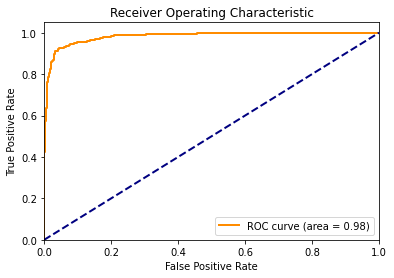

In [26]:
from sklearn.preprocessing import label_binarize
# Convert true_labels to binary format for ROC calculation
true_labels_binary = label_binarize(true_labels, classes=[0, 1])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), [prob[1] for prob in predicted_probs])
roc_auc = auc(fpr, tpr)
%matplotlib inline
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

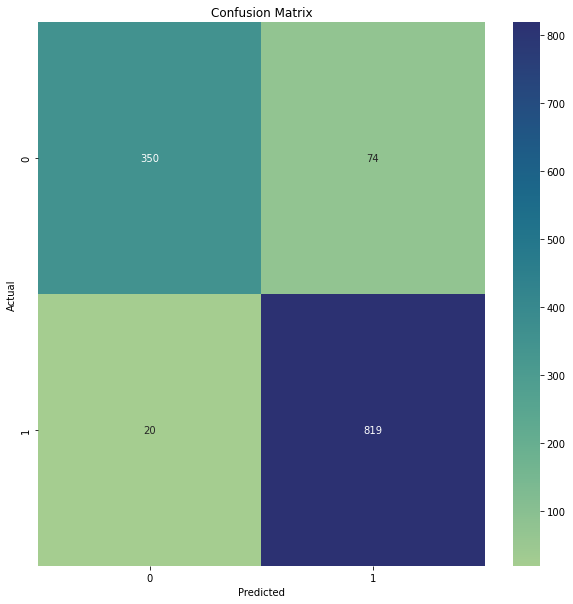

In [27]:
confusion = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='d', cmap='crest')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

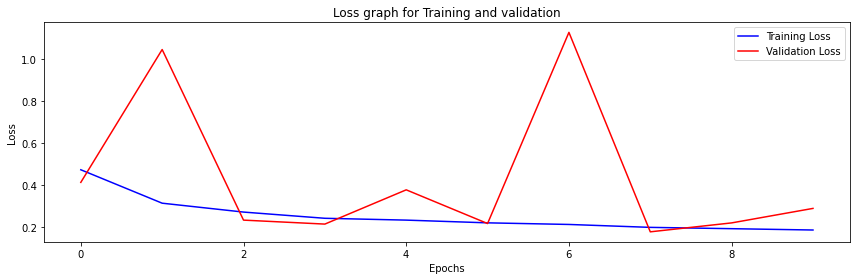

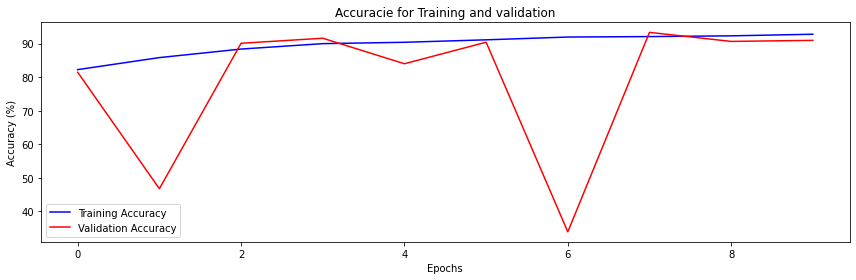

In [28]:
# Plot losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for Training and validation')

plt.tight_layout()
plt.show()


#Plot accuracies
plt.figure(figsize=(12, 4))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracie for Training and validation')

plt.tight_layout()
plt.show()

## Improved Resnet Model

By adding drop out layers and l2 regularisation

In [29]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Downsampling layer if there's a need to adjust dimensions
        self.downsample = downsample

    def forward(self, x):
        residual = x
        # Apply downsampling if defined
        if self.downsample is not None:
            residual = self.downsample(x)

        # First convolutional operation
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Second convolutional operation
        out = self.conv2(out)
        out = self.bn2(out)

        # Adding back the residual
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=36, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Stack of residual blocks forming the four layers of the ResNet
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        # Handle downsampling at the first block of the layer if needed
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
        # Create the layer by stacking residual blocks
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))  # No stride change, no downsampling

        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial convolution and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # Apply all four layers in sequence
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Pooling and dropout
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def imp_resnet34(num_classes=36, dropout_rate=0.5):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes, dropout_rate=dropout_rate)

In [30]:
# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on: {device}')

model_1 = imp_resnet34().to(device)
print(model_1)

Training on: cuda:0
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001, weight_decay = 0.0005)

def train_val_model(model, train_loader, validation_loader, criterion, optimizer, epochs, patience):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0.0
        total_train = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            targets = targets.squeeze().long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
                targets = targets.squeeze().long()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()
                
        # Calculate validation accuracy and loss
        avg_val_loss = val_loss / len(validation_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1} out of {epochs}')
            break
    
    # Save the best model
    if best_model_state is not None:
        torch.save(best_model_state, 'manishbi_hsriram_swanitha_project_checkpoint2_resnet.pkl')
        print(f'Saved best model with validation loss: {best_val_loss:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

epochs = 15
patience = 2  # Number of epochs with no improvement after which training will be stopped
train_losses, val_losses, train_accuracies, val_accuracies = train_val_model(model_1, train_loader, val_loader, criterion, optimizer, epochs=epochs, patience=patience)

# Load the best model
model_1.load_state_dict(torch.load('manishbi_hsriram_swanitha_project_checkpoint2_resnet.pkl'))

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/15, Loss: 0.4542, Training Accuracy: 83.28%
Validation Loss: 1.1365, Validation Accuracy: 33.84%
Epoch 2/15, Loss: 0.3116, Training Accuracy: 86.25%
Validation Loss: 0.5719, Validation Accuracy: 69.10%
Epoch 3/15, Loss: 0.2934, Training Accuracy: 87.13%
Validation Loss: 0.6582, Validation Accuracy: 80.82%
Epoch 4/15, Loss: 0.2756, Training Accuracy: 88.03%
Validation Loss: 0.4405, Validation Accuracy: 84.23%
Epoch 5/15, Loss: 0.2781, Training Accuracy: 87.91%
Validation Loss: 0.5085, Validation Accuracy: 80.59%
Epoch 6/15, Loss: 0.2662, Training Accuracy: 88.30%
Validation Loss: 1.7682, Validation Accuracy: 33.84%
Early stopping at epoch 6 out of 15
Saved best model with validation loss: 0.4405


<All keys matched successfully>

In [36]:
# Ensure device is set
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model in evaluation mode
model_1.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []
predicted_probs = []
test_accuracies_early = []
test_losses = []
best_test_accuracy = 0.0

# No gradient calculation needed during testing
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU for further processing
        true_labels.extend(labels.cpu().numpy())  # Move true labels back to CPU for further processing
        predicted_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Store softmax probabilities

# Calculate test accuracy and loss
test_accuracy = 100 * correct_test / total_test
test_loss = test_loss / len(test_loader)

# Storing the test loss values for each batch into a list
test_losses.append(test_loss)
# Similarly storing accuracies into a list
test_accuracies_early.append(test_accuracy)

if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy

# Calculating the precision, recall, and F1 score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {best_test_accuracy:.2f}%')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/pytorch/1.13.1-CUDA-11.8.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 92.87%
Final Precision: 0.9310
Final Recall: 0.9287
Final F1 Score: 0.9272


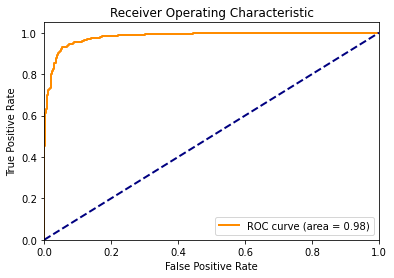

In [37]:
# Convert true_labels to binary format for ROC calculation
true_labels_binary = label_binarize(true_labels, classes=[0, 1])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), [prob[1] for prob in predicted_probs])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

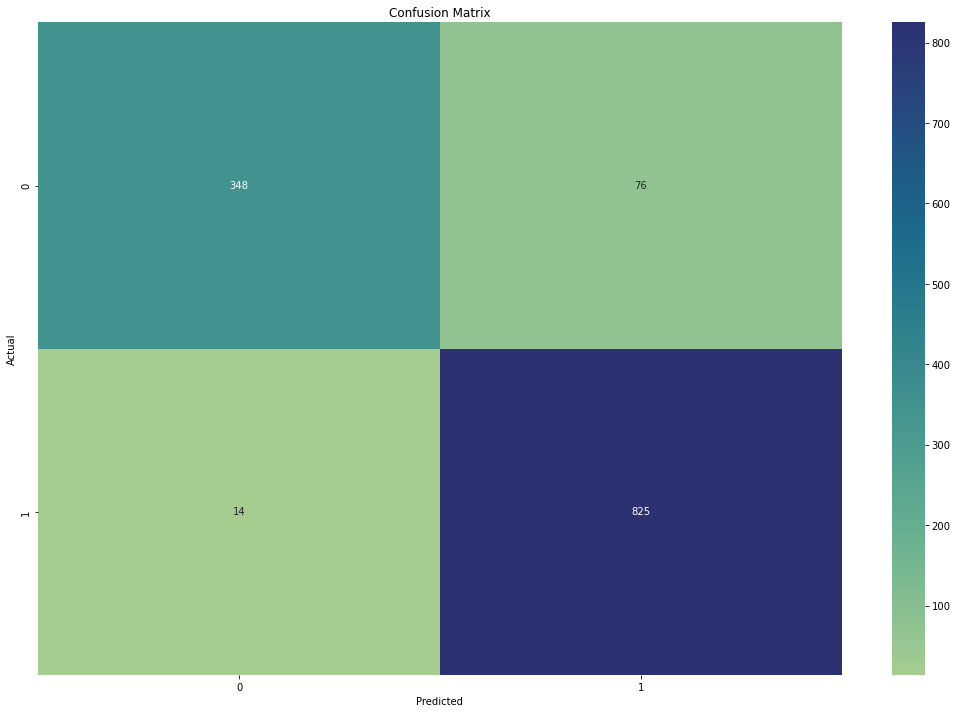

In [38]:
# Confusion Matrix
confusion = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(18, 12))
sns.heatmap(confusion, annot=True, fmt='d', cmap='crest')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

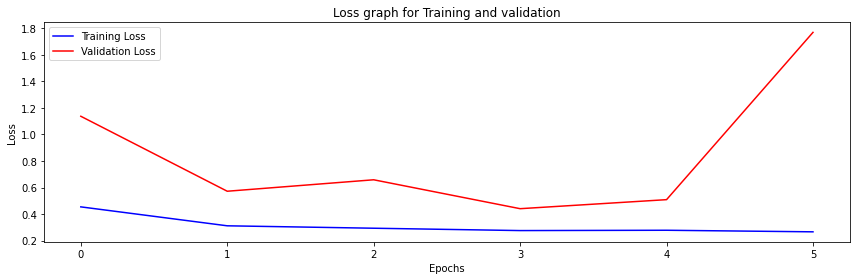

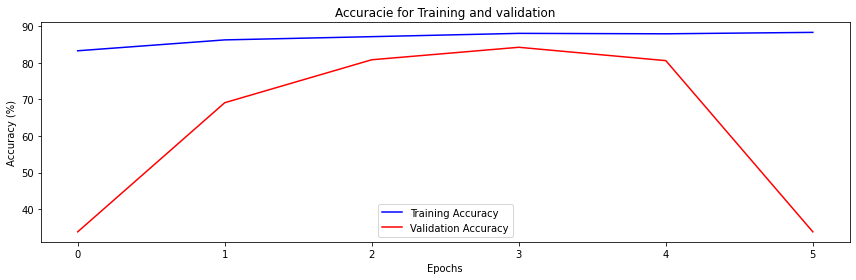

In [39]:
# Plot losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for Training and validation')

plt.tight_layout()
plt.show()


#Plot accuracies
plt.figure(figsize=(12, 4))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracie for Training and validation')

plt.tight_layout()
plt.show()